In [2]:
%pylab inline
import mxnet as mx
import pandas
import seaborn; seaborn.set_style('whitegrid')
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Matrix Factorization on Synthetic Data

In [4]:
X = numpy.random.randn(250, 250)

In [5]:
X

array([[-0.67463098,  0.88749072,  0.81408134, ...,  0.48010479,
        -1.74579175, -0.1334616 ],
       [-0.36026676, -1.71324857,  1.8314569 , ..., -0.09029531,
         0.51953601,  0.64899988],
       [-0.66995359, -0.65365397,  1.06540951, ...,  0.12724187,
        -1.47628582, -0.02334055],
       ..., 
       [-2.54661981, -1.31515794,  1.07583031, ..., -0.07130901,
        -1.1093201 ,  1.16919515],
       [ 0.54432855, -0.9327399 , -0.01946309, ..., -0.11639278,
        -0.1566439 , -1.56561615],
       [ 0.13837779,  1.22051044,  0.69056767, ..., -0.69255692,
         0.2524371 ,  0.87187347]])

In [6]:
n = 35000
i = numpy.random.randint(250, size=n) # Generate random row indexes

In [7]:
i

array([ 68, 147, 147, ...,  62,  87, 225])

In [10]:
i.shape

(35000,)

In [11]:
j = numpy.random.randint(250, size=n) # Generate random column indexes

In [12]:
j.shape

(35000,)

In [13]:
X_values = X[i, j] # Extract those values from the matrix

In [14]:
X.shape

(250, 250)

In [15]:
X_values.shape

(35000,)

In [16]:
X_values

array([ 0.98208805, -0.38028227, -0.54222312, ..., -0.77687652,
       -1.35549063,  1.11865537])

In [17]:
# Interesting X_values is now a 1-dimensional array

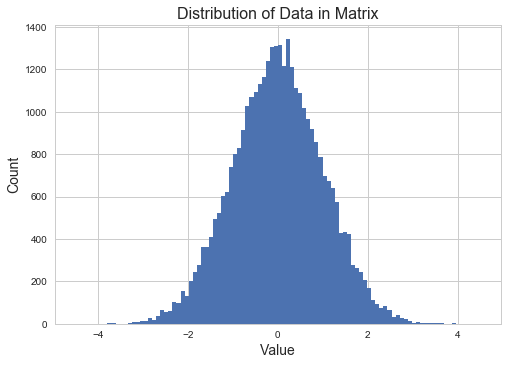

In [18]:
plt.title("Distribution of Data in Matrix", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Value", fontsize=14)
plt.hist(X_values, bins=100)
plt.show()

In [19]:
# A core component of the matrix factorization model will be the embedding layer

In [20]:
user = mx.symbol.Variable("user") # Name one of our input variables, the user index
# Define an embedding layer that takes in a user index and outputs a dense 25 dimensional vector
user = mx.symbol.Embedding(data=user, input_dim=250, output_dim=25) 
                                                      
movie = mx.symbol.Variable("movie") # Name the other input variable, the movie index
# Define an embedding layer that takes in a movie index and outputs a dense 25 dimensional vector
movie = mx.symbol.Embedding(data=movie, input_dim=250, output_dim=25)

# Name the output variable. "softmax_label" is the default name for outputs in mxnet
y_true = mx.symbol.Variable("softmax_label")

# Define the dot product between the two variables, which is the elementwise multiplication and a sum
y_pred = mx.symbol.sum_axis(data=(user * movie), axis=1)
y_pred = mx.symbol.flatten(y_pred)

# The linear regression output defines the loss we want to use to train the network, mse in this case
y_pred = mx.symbol.LinearRegressionOutput(data=y_pred, label=y_true)

In [21]:
# We next need to convert our data from the form of three vectors (the row ids, column ids, and values) 
# into an appropriate iterator that MXNet can use. 

In [22]:
# Build a data iterator for training data using the first 25,000 samples
X_train = mx.io.NDArrayIter({'user': i[:25000], 'movie': j[:25000]}, label=X_values[:25000], batch_size=1000)

# Build a data iterator for evaluation data using the last 10,000 samples
X_eval = mx.io.NDArrayIter({'user': i[25000:], 'movie': j[25000:]}, label=X_values[25000:], batch_size=1000)

In [23]:
# We now need to specify that the architecture is a model to be trained using the Module wrapper. 

In [24]:
X_train

In [25]:
X_eval

In [29]:
model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'movie'), symbol=y_pred)

In [30]:
# Now we need to fit the network using the fit function, similar to scikit-learn and other popular machine learning packages

In [31]:
model.fit(X_train, num_epoch=5, eval_metric='rmse', eval_data=X_eval)

INFO:root:Epoch[0] Train-rmse=0.996622
INFO:root:Epoch[0] Time cost=0.391
INFO:root:Epoch[0] Validation-rmse=1.004751
INFO:root:Epoch[1] Train-rmse=0.996622
INFO:root:Epoch[1] Time cost=0.345
INFO:root:Epoch[1] Validation-rmse=1.004751
INFO:root:Epoch[2] Train-rmse=0.996622
INFO:root:Epoch[2] Time cost=0.394
INFO:root:Epoch[2] Validation-rmse=1.004751
INFO:root:Epoch[3] Train-rmse=0.996622
INFO:root:Epoch[3] Time cost=0.370
INFO:root:Epoch[3] Validation-rmse=1.004751
INFO:root:Epoch[4] Train-rmse=0.996622
INFO:root:Epoch[4] Time cost=0.351
INFO:root:Epoch[4] Validation-rmse=1.004751


In [32]:
# It doesn't really seem like it's training because the validation mean squared error is not changing epoch by epoch. 
# This is because in the dataset we randomly generated there was no connection between the values in the matrix 
# that could be exploited by a machine learning model.

In [33]:
# Let's now create some synthetic data that has structure that can be exploited instead of evenly distributed random values

In [34]:
a = numpy.random.normal(0, 1, size=(250, 25)) # Generate random numbers for the first skinny matrix
b = numpy.random.normal(0, 1, size=(25, 250)) # Generate random numbers for the second skinny matrix

In [35]:
a.shape

(250, 25)

In [36]:
b.shape

(25, 250)

In [37]:
a

array([[ 1.70381858,  0.36653098, -0.62032956, ..., -1.40057199,
         0.53909944,  1.8547906 ],
       [-1.19044675, -0.19322598,  0.36971156, ...,  0.48120005,
        -0.08580106, -0.18860878],
       [-0.09221706,  0.31798052,  1.26568513, ...,  1.21657921,
        -0.02265196, -0.90844015],
       ..., 
       [-1.1972677 ,  0.86405186, -0.46280242, ..., -0.09852945,
        -0.70956469, -0.82176949],
       [ 1.99979202, -1.00885764, -0.12675353, ...,  1.29309889,
         0.728085  , -0.79746142],
       [ 0.15522909, -0.66997109, -0.7423736 , ..., -0.23497383,
         0.82910812,  0.62231172]])

In [38]:
b

array([[-0.57687427, -0.01312388,  0.92782751, ...,  1.45518142,
        -0.81933293, -1.01981062],
       [ 0.17249914,  1.5448449 , -1.57946029, ..., -0.96180685,
         0.93549481,  1.02439953],
       [-0.927114  , -0.86866371, -0.11221516, ..., -2.19402515,
        -1.0348784 ,  0.30343405],
       ..., 
       [-1.73547137,  0.09317629,  0.00284536, ..., -0.63986416,
         0.24769594,  2.46676783],
       [-0.59632197, -0.3095286 ,  0.29935021, ...,  1.96668298,
         1.08507703,  0.28591216],
       [ 0.82390578,  1.83581462, -0.79032304, ..., -0.78623479,
         1.36719049, -0.02975974]])

In [39]:
X = a.dot(b) # Build our real data matrix from the dot product of the two skinny matrices

In [40]:
X

array([[ 1.72750149,  8.16318909, -0.60945691, ...,  9.40101339,
        -0.50744991, -6.53538723],
       [-2.80654802, -4.8624129 ,  2.56515088, ..., -2.80102737,
         4.05711954,  1.09270993],
       [-0.61596505, -1.39122249,  0.43179326, ...,  2.62715824,
         0.48809755,  5.34559818],
       ..., 
       [ 2.29218354, -6.85681411, -4.86699999, ..., -7.25295463,
        -1.54643053, -3.68422548],
       [-6.93011927, -2.79995337,  6.49877858, ..., -0.15313444,
         0.01115016, -0.0682902 ],
       [ 5.90004484, -0.8150776 ,  9.61373715, ..., -6.86728821,
         0.25841292, -3.26942522]])

In [41]:
X_train = mx.io.NDArrayIter({'user': i[:25000], 'movie': j[:25000]}, label=X_values[:25000], batch_size=100)
X_eval = mx.io.NDArrayIter({'user': i[25000:], 'movie': j[25000:]}, label=X_values[25000:], batch_size=100)

In [42]:
# Let's take a look at the distribution of data like before by plotting a histogram of the values in this matrix.

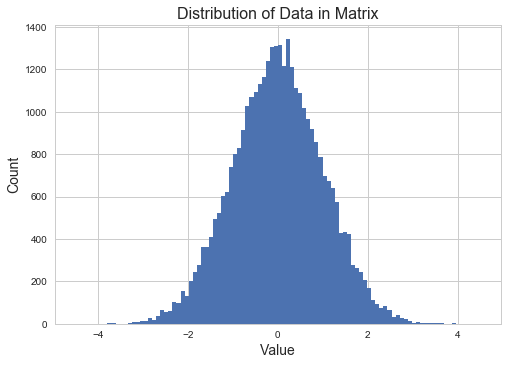

In [43]:
plt.title("Distribution of Data in Matrix", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Value", fontsize=14)
plt.hist(X_values, bins=100)
plt.show()

In [44]:
# Now that we've created this new dataset and the appropriate iterators, we can create the model again and try to learn something.

In [45]:
model = mx.module.Module(context=mx.gpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, eval_metric='mse', eval_data=X_eval)

RuntimeError: simple_bind error. Arguments:
user: (100,)
movie: (100,)
softmax_label: (100,)
[11:03:19] C:\projects\mxnet-distro-win\mxnet-build\src\storage\storage.cc:113: Compile with USE_CUDA=1 to enable GPU usage

In [46]:
model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, eval_metric='mse', eval_data=X_eval)

INFO:root:Epoch[0] Train-mse=0.993696
INFO:root:Epoch[0] Time cost=0.509
INFO:root:Epoch[0] Validation-mse=1.009833
INFO:root:Epoch[1] Train-mse=0.993695
INFO:root:Epoch[1] Time cost=0.497
INFO:root:Epoch[1] Validation-mse=1.009833
INFO:root:Epoch[2] Train-mse=0.993695
INFO:root:Epoch[2] Time cost=0.504
INFO:root:Epoch[2] Validation-mse=1.009833
INFO:root:Epoch[3] Train-mse=0.993694
INFO:root:Epoch[3] Time cost=0.493
INFO:root:Epoch[3] Validation-mse=1.009833
INFO:root:Epoch[4] Train-mse=0.993694
INFO:root:Epoch[4] Time cost=0.505
INFO:root:Epoch[4] Validation-mse=1.009833


In [48]:
model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=50, eval_metric='mse', eval_data=X_eval)

INFO:root:Epoch[0] Train-mse=0.993695
INFO:root:Epoch[0] Time cost=0.516
INFO:root:Epoch[0] Validation-mse=1.009831
INFO:root:Epoch[1] Train-mse=0.993694
INFO:root:Epoch[1] Time cost=0.483
INFO:root:Epoch[1] Validation-mse=1.009830
INFO:root:Epoch[2] Train-mse=0.993694
INFO:root:Epoch[2] Time cost=0.508
INFO:root:Epoch[2] Validation-mse=1.009830
INFO:root:Epoch[3] Train-mse=0.993693
INFO:root:Epoch[3] Time cost=0.494
INFO:root:Epoch[3] Validation-mse=1.009830
INFO:root:Epoch[4] Train-mse=0.993693
INFO:root:Epoch[4] Time cost=0.506
INFO:root:Epoch[4] Validation-mse=1.009830
INFO:root:Epoch[5] Train-mse=0.993692
INFO:root:Epoch[5] Time cost=0.490
INFO:root:Epoch[5] Validation-mse=1.009830
INFO:root:Epoch[6] Train-mse=0.993692
INFO:root:Epoch[6] Time cost=0.492
INFO:root:Epoch[6] Validation-mse=1.009830
INFO:root:Epoch[7] Train-mse=0.993691
INFO:root:Epoch[7] Time cost=0.487
INFO:root:Epoch[7] Validation-mse=1.009830
INFO:root:Epoch[8] Train-mse=0.993691
INFO:root:Epoch[8] Time cost=0.481

In [49]:
# It doesn't seem like we're learning anything again because neither the training nor the validation mse goes down 
# epoch by epoch! The problem this time is that, like many matrix factorization algorithms, 
# we are using stochastic gradient descent (SGD) which is tricky to set an appropriate learning rate for.

In [50]:
# since we've implemented matrix factorization using Apache MXNet 
# we can easily use a different optimizer. Adam is a popular optimizer 
# that can automatically tune the learning rate to get better results, 
# and we can specify that we want to use it by adding in optimizer='adam' to the fit function.

model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', eval_metric='mse', eval_data=X_eval)

INFO:root:Epoch[0] Train-mse=0.973924
INFO:root:Epoch[0] Time cost=0.604
INFO:root:Epoch[0] Validation-mse=0.970028
INFO:root:Epoch[1] Train-mse=0.736726
INFO:root:Epoch[1] Time cost=0.612
INFO:root:Epoch[1] Validation-mse=1.041844
INFO:root:Epoch[2] Train-mse=0.571460
INFO:root:Epoch[2] Time cost=0.627
INFO:root:Epoch[2] Validation-mse=1.143264
INFO:root:Epoch[3] Train-mse=0.498171
INFO:root:Epoch[3] Time cost=0.599
INFO:root:Epoch[3] Validation-mse=1.225590
INFO:root:Epoch[4] Train-mse=0.458037
INFO:root:Epoch[4] Time cost=0.616
INFO:root:Epoch[4] Validation-mse=1.294935


In [51]:
# This is much worse!

In [52]:
model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=50, optimizer='adam', eval_metric='mse', eval_data=X_eval)

INFO:root:Epoch[0] Train-mse=0.977053
INFO:root:Epoch[0] Time cost=0.614
INFO:root:Epoch[0] Validation-mse=0.975585
INFO:root:Epoch[1] Train-mse=0.748049
INFO:root:Epoch[1] Time cost=0.596
INFO:root:Epoch[1] Validation-mse=1.037158
INFO:root:Epoch[2] Train-mse=0.582237
INFO:root:Epoch[2] Time cost=0.610
INFO:root:Epoch[2] Validation-mse=1.129912
INFO:root:Epoch[3] Train-mse=0.505866
INFO:root:Epoch[3] Time cost=0.609
INFO:root:Epoch[3] Validation-mse=1.209870
INFO:root:Epoch[4] Train-mse=0.463155
INFO:root:Epoch[4] Time cost=0.613
INFO:root:Epoch[4] Validation-mse=1.276705
INFO:root:Epoch[5] Train-mse=0.435737
INFO:root:Epoch[5] Time cost=0.596
INFO:root:Epoch[5] Validation-mse=1.335533
INFO:root:Epoch[6] Train-mse=0.416728
INFO:root:Epoch[6] Time cost=0.610
INFO:root:Epoch[6] Validation-mse=1.389283
INFO:root:Epoch[7] Train-mse=0.402753
INFO:root:Epoch[7] Time cost=0.612
INFO:root:Epoch[7] Validation-mse=1.438767
INFO:root:Epoch[8] Train-mse=0.391903
INFO:root:Epoch[8] Time cost=0.646

In [53]:
# Why worse?
# Oh my, I forget one step.

In [54]:
n = 35000
i = numpy.random.randint(250, size=n)
j = numpy.random.randint(250, size=n)
X_values = X[i, j]

In [55]:
X_train = mx.io.NDArrayIter({'user': i[:25000], 'movie': j[:25000]}, label=X_values[:25000], batch_size=100)
X_eval = mx.io.NDArrayIter({'user': i[25000:], 'movie': j[25000:]}, label=X_values[25000:], batch_size=100)

In [56]:
model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', eval_metric='mse', eval_data=X_eval)

INFO:root:Epoch[0] Train-mse=24.956738
INFO:root:Epoch[0] Time cost=0.620
INFO:root:Epoch[0] Validation-mse=22.115440
INFO:root:Epoch[1] Train-mse=16.081433
INFO:root:Epoch[1] Time cost=0.610
INFO:root:Epoch[1] Validation-mse=14.584486
INFO:root:Epoch[2] Train-mse=8.659330
INFO:root:Epoch[2] Time cost=0.596
INFO:root:Epoch[2] Validation-mse=10.950654
INFO:root:Epoch[3] Train-mse=5.579079
INFO:root:Epoch[3] Time cost=0.600
INFO:root:Epoch[3] Validation-mse=8.782867
INFO:root:Epoch[4] Train-mse=3.947707
INFO:root:Epoch[4] Time cost=0.596
INFO:root:Epoch[4] Validation-mse=7.254399


In [57]:
model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=50, optimizer='adam', eval_metric='mse', eval_data=X_eval)

INFO:root:Epoch[0] Train-mse=24.936014
INFO:root:Epoch[0] Time cost=0.612
INFO:root:Epoch[0] Validation-mse=22.102140
INFO:root:Epoch[1] Train-mse=16.153727
INFO:root:Epoch[1] Time cost=0.614
INFO:root:Epoch[1] Validation-mse=14.920806
INFO:root:Epoch[2] Train-mse=8.807999
INFO:root:Epoch[2] Time cost=0.608
INFO:root:Epoch[2] Validation-mse=11.189937
INFO:root:Epoch[3] Train-mse=5.609569
INFO:root:Epoch[3] Time cost=0.601
INFO:root:Epoch[3] Validation-mse=8.924298
INFO:root:Epoch[4] Train-mse=3.937565
INFO:root:Epoch[4] Time cost=0.605
INFO:root:Epoch[4] Validation-mse=7.302597
INFO:root:Epoch[5] Train-mse=2.910115
INFO:root:Epoch[5] Time cost=0.599
INFO:root:Epoch[5] Validation-mse=6.046915
INFO:root:Epoch[6] Train-mse=2.217481
INFO:root:Epoch[6] Time cost=0.600
INFO:root:Epoch[6] Validation-mse=5.032041
INFO:root:Epoch[7] Train-mse=1.727568
INFO:root:Epoch[7] Time cost=0.599
INFO:root:Epoch[7] Validation-mse=4.188002
INFO:root:Epoch[8] Train-mse=1.367693
INFO:root:Epoch[8] Time cost=

In [59]:
# It is much better! Validation MSE goes down from 22.102140
# to 0.155702

In [60]:
# Let's now take a look at what deep matrix factorization would look like

In [61]:
user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=250, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=250, output_dim=25)

y_true = mx.symbol.Variable("softmax_label")

# No longer using a dot product
#y_pred = mx.symbol.sum_axis(data=(user * movie), axis=1)
#y_pred = mx.symbol.flatten(y_pred)
#y_pred = mx.symbol.LinearRegressionOutput(data=y_pred, label=y_true)

# Instead of taking the dot product we want to concatenate the inputs together
nn = mx.symbol.concat(user, movie)
nn = mx.symbol.flatten(nn)

# Now we pass both the movie and user factors into a one layer neural network
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)

# We use a ReLU activation function here, but one could use any type including PReLU or sigmoid
nn = mx.symbol.Activation(data=nn, act_type='relu')

# Now we define our output layer, a dense layer with a single neuron containing the prediction
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

# We don't put an activation on the prediction here because it is the output of the model
y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),), 
          eval_metric='mse', eval_data=X_eval)

INFO:root:Epoch[0] Train-mse=25.847689
INFO:root:Epoch[0] Time cost=1.092
INFO:root:Epoch[0] Validation-mse=25.376458
INFO:root:Epoch[1] Train-mse=25.483679
INFO:root:Epoch[1] Time cost=0.958
INFO:root:Epoch[1] Validation-mse=25.080447
INFO:root:Epoch[2] Train-mse=24.802418
INFO:root:Epoch[2] Time cost=0.922
INFO:root:Epoch[2] Validation-mse=24.872164
INFO:root:Epoch[3] Train-mse=24.292984
INFO:root:Epoch[3] Time cost=0.912
INFO:root:Epoch[3] Validation-mse=24.759141
INFO:root:Epoch[4] Train-mse=23.929415
INFO:root:Epoch[4] Time cost=0.960
INFO:root:Epoch[4] Validation-mse=24.705151


In [62]:
model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=50, optimizer='adam', optimizer_params=(('learning_rate', 0.001),), 
          eval_metric='mse', eval_data=X_eval)

INFO:root:Epoch[0] Train-mse=25.847733
INFO:root:Epoch[0] Time cost=1.104
INFO:root:Epoch[0] Validation-mse=25.385656
INFO:root:Epoch[1] Train-mse=25.552469
INFO:root:Epoch[1] Time cost=0.920
INFO:root:Epoch[1] Validation-mse=25.308643
INFO:root:Epoch[2] Train-mse=24.944706
INFO:root:Epoch[2] Time cost=0.916
INFO:root:Epoch[2] Validation-mse=25.050344
INFO:root:Epoch[3] Train-mse=24.311352
INFO:root:Epoch[3] Time cost=0.979
INFO:root:Epoch[3] Validation-mse=24.926112
INFO:root:Epoch[4] Train-mse=23.910709
INFO:root:Epoch[4] Time cost=0.960
INFO:root:Epoch[4] Validation-mse=24.867650
INFO:root:Epoch[5] Train-mse=23.627007
INFO:root:Epoch[5] Time cost=1.136
INFO:root:Epoch[5] Validation-mse=24.782592
INFO:root:Epoch[6] Train-mse=23.357974
INFO:root:Epoch[6] Time cost=0.983
INFO:root:Epoch[6] Validation-mse=24.643546
INFO:root:Epoch[7] Train-mse=23.074098
INFO:root:Epoch[7] Time cost=0.978
INFO:root:Epoch[7] Validation-mse=24.496475
INFO:root:Epoch[8] Train-mse=22.798168
INFO:root:Epoch[8

In [63]:
model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=500, optimizer='adam', optimizer_params=(('learning_rate', 0.001),), 
          eval_metric='mse', eval_data=X_eval)

INFO:root:Epoch[0] Train-mse=25.848159
INFO:root:Epoch[0] Time cost=1.186
INFO:root:Epoch[0] Validation-mse=25.387798
INFO:root:Epoch[1] Train-mse=25.569714
INFO:root:Epoch[1] Time cost=0.919
INFO:root:Epoch[1] Validation-mse=25.320081
INFO:root:Epoch[2] Train-mse=25.043951
INFO:root:Epoch[2] Time cost=0.906
INFO:root:Epoch[2] Validation-mse=25.091340
INFO:root:Epoch[3] Train-mse=24.445183
INFO:root:Epoch[3] Time cost=0.920
INFO:root:Epoch[3] Validation-mse=24.873782
INFO:root:Epoch[4] Train-mse=23.939380
INFO:root:Epoch[4] Time cost=0.915
INFO:root:Epoch[4] Validation-mse=24.753185
INFO:root:Epoch[5] Train-mse=23.543816
INFO:root:Epoch[5] Time cost=0.934
INFO:root:Epoch[5] Validation-mse=24.649060
INFO:root:Epoch[6] Train-mse=23.203896
INFO:root:Epoch[6] Time cost=0.932
INFO:root:Epoch[6] Validation-mse=24.566225
INFO:root:Epoch[7] Train-mse=22.924739
INFO:root:Epoch[7] Time cost=0.941
INFO:root:Epoch[7] Validation-mse=24.486677
INFO:root:Epoch[8] Train-mse=22.672756
INFO:root:Epoch[8

INFO:root:Epoch[68] Train-mse=16.825626
INFO:root:Epoch[68] Time cost=0.902
INFO:root:Epoch[68] Validation-mse=22.233091
INFO:root:Epoch[69] Train-mse=16.753216
INFO:root:Epoch[69] Time cost=0.892
INFO:root:Epoch[69] Validation-mse=22.228784
INFO:root:Epoch[70] Train-mse=16.679615
INFO:root:Epoch[70] Time cost=0.904
INFO:root:Epoch[70] Validation-mse=22.229132
INFO:root:Epoch[71] Train-mse=16.608598
INFO:root:Epoch[71] Time cost=0.906
INFO:root:Epoch[71] Validation-mse=22.224241
INFO:root:Epoch[72] Train-mse=16.538689
INFO:root:Epoch[72] Time cost=0.884
INFO:root:Epoch[72] Validation-mse=22.217995
INFO:root:Epoch[73] Train-mse=16.467817
INFO:root:Epoch[73] Time cost=0.885
INFO:root:Epoch[73] Validation-mse=22.206528
INFO:root:Epoch[74] Train-mse=16.393900
INFO:root:Epoch[74] Time cost=0.886
INFO:root:Epoch[74] Validation-mse=22.193419
INFO:root:Epoch[75] Train-mse=16.323850
INFO:root:Epoch[75] Time cost=0.884
INFO:root:Epoch[75] Validation-mse=22.173954
INFO:root:Epoch[76] Train-mse=16

INFO:root:Epoch[135] Train-mse=12.292470
INFO:root:Epoch[135] Time cost=0.906
INFO:root:Epoch[135] Validation-mse=21.661095
INFO:root:Epoch[136] Train-mse=12.224216
INFO:root:Epoch[136] Time cost=0.886
INFO:root:Epoch[136] Validation-mse=21.660185
INFO:root:Epoch[137] Train-mse=12.155890
INFO:root:Epoch[137] Time cost=0.904
INFO:root:Epoch[137] Validation-mse=21.660220
INFO:root:Epoch[138] Train-mse=12.090867
INFO:root:Epoch[138] Time cost=0.887
INFO:root:Epoch[138] Validation-mse=21.649239
INFO:root:Epoch[139] Train-mse=12.029423
INFO:root:Epoch[139] Time cost=0.886
INFO:root:Epoch[139] Validation-mse=21.648598
INFO:root:Epoch[140] Train-mse=11.961244
INFO:root:Epoch[140] Time cost=0.888
INFO:root:Epoch[140] Validation-mse=21.640517
INFO:root:Epoch[141] Train-mse=11.897931
INFO:root:Epoch[141] Time cost=0.887
INFO:root:Epoch[141] Validation-mse=21.644999
INFO:root:Epoch[142] Train-mse=11.837188
INFO:root:Epoch[142] Time cost=0.903
INFO:root:Epoch[142] Validation-mse=21.652577
INFO:roo

INFO:root:Epoch[201] Time cost=0.879
INFO:root:Epoch[201] Validation-mse=21.663384
INFO:root:Epoch[202] Train-mse=8.935901
INFO:root:Epoch[202] Time cost=0.890
INFO:root:Epoch[202] Validation-mse=21.669949
INFO:root:Epoch[203] Train-mse=8.899006
INFO:root:Epoch[203] Time cost=0.900
INFO:root:Epoch[203] Validation-mse=21.684325
INFO:root:Epoch[204] Train-mse=8.865191
INFO:root:Epoch[204] Time cost=0.883
INFO:root:Epoch[204] Validation-mse=21.699230
INFO:root:Epoch[205] Train-mse=8.830694
INFO:root:Epoch[205] Time cost=0.879
INFO:root:Epoch[205] Validation-mse=21.719462
INFO:root:Epoch[206] Train-mse=8.792903
INFO:root:Epoch[206] Time cost=0.889
INFO:root:Epoch[206] Validation-mse=21.731825
INFO:root:Epoch[207] Train-mse=8.759060
INFO:root:Epoch[207] Time cost=0.883
INFO:root:Epoch[207] Validation-mse=21.743673
INFO:root:Epoch[208] Train-mse=8.723750
INFO:root:Epoch[208] Time cost=0.900
INFO:root:Epoch[208] Validation-mse=21.748706
INFO:root:Epoch[209] Train-mse=8.688772
INFO:root:Epoch[

INFO:root:Epoch[268] Train-mse=7.023478
INFO:root:Epoch[268] Time cost=0.931
INFO:root:Epoch[268] Validation-mse=22.785573
INFO:root:Epoch[269] Train-mse=7.002723
INFO:root:Epoch[269] Time cost=0.916
INFO:root:Epoch[269] Validation-mse=22.791696
INFO:root:Epoch[270] Train-mse=6.978629
INFO:root:Epoch[270] Time cost=0.918
INFO:root:Epoch[270] Validation-mse=22.818440
INFO:root:Epoch[271] Train-mse=6.958240
INFO:root:Epoch[271] Time cost=0.933
INFO:root:Epoch[271] Validation-mse=22.813273
INFO:root:Epoch[272] Train-mse=6.936550
INFO:root:Epoch[272] Time cost=0.913
INFO:root:Epoch[272] Validation-mse=22.840325
INFO:root:Epoch[273] Train-mse=6.915484
INFO:root:Epoch[273] Time cost=0.916
INFO:root:Epoch[273] Validation-mse=22.859999
INFO:root:Epoch[274] Train-mse=6.893666
INFO:root:Epoch[274] Time cost=1.068
INFO:root:Epoch[274] Validation-mse=22.882443
INFO:root:Epoch[275] Train-mse=6.873934
INFO:root:Epoch[275] Time cost=0.960
INFO:root:Epoch[275] Validation-mse=22.877319
INFO:root:Epoch[

INFO:root:Epoch[334] Validation-mse=23.616823
INFO:root:Epoch[335] Train-mse=5.822039
INFO:root:Epoch[335] Time cost=0.965
INFO:root:Epoch[335] Validation-mse=23.614202
INFO:root:Epoch[336] Train-mse=5.810315
INFO:root:Epoch[336] Time cost=0.949
INFO:root:Epoch[336] Validation-mse=23.651236
INFO:root:Epoch[337] Train-mse=5.793720
INFO:root:Epoch[337] Time cost=0.935
INFO:root:Epoch[337] Validation-mse=23.652448
INFO:root:Epoch[338] Train-mse=5.781040
INFO:root:Epoch[338] Time cost=0.934
INFO:root:Epoch[338] Validation-mse=23.674046
INFO:root:Epoch[339] Train-mse=5.763563
INFO:root:Epoch[339] Time cost=1.366
INFO:root:Epoch[339] Validation-mse=23.702261
INFO:root:Epoch[340] Train-mse=5.750300
INFO:root:Epoch[340] Time cost=0.973
INFO:root:Epoch[340] Validation-mse=23.700256
INFO:root:Epoch[341] Train-mse=5.737217
INFO:root:Epoch[341] Time cost=1.034
INFO:root:Epoch[341] Validation-mse=23.717493
INFO:root:Epoch[342] Train-mse=5.721644
INFO:root:Epoch[342] Time cost=1.093
INFO:root:Epoch[

INFO:root:Epoch[401] Time cost=0.920
INFO:root:Epoch[401] Validation-mse=24.471778
INFO:root:Epoch[402] Train-mse=5.040441
INFO:root:Epoch[402] Time cost=0.900
INFO:root:Epoch[402] Validation-mse=24.486399
INFO:root:Epoch[403] Train-mse=5.031488
INFO:root:Epoch[403] Time cost=0.898
INFO:root:Epoch[403] Validation-mse=24.505600
INFO:root:Epoch[404] Train-mse=5.024807
INFO:root:Epoch[404] Time cost=0.899
INFO:root:Epoch[404] Validation-mse=24.517655
INFO:root:Epoch[405] Train-mse=5.017347
INFO:root:Epoch[405] Time cost=0.914
INFO:root:Epoch[405] Validation-mse=24.539051
INFO:root:Epoch[406] Train-mse=5.005973
INFO:root:Epoch[406] Time cost=0.886
INFO:root:Epoch[406] Validation-mse=24.547079
INFO:root:Epoch[407] Train-mse=5.000131
INFO:root:Epoch[407] Time cost=0.915
INFO:root:Epoch[407] Validation-mse=24.564310
INFO:root:Epoch[408] Train-mse=4.991834
INFO:root:Epoch[408] Time cost=0.889
INFO:root:Epoch[408] Validation-mse=24.579633
INFO:root:Epoch[409] Train-mse=4.983038
INFO:root:Epoch[

INFO:root:Epoch[467] Validation-mse=25.159779
INFO:root:Epoch[468] Train-mse=4.591389
INFO:root:Epoch[468] Time cost=0.908
INFO:root:Epoch[468] Validation-mse=25.183773
INFO:root:Epoch[469] Train-mse=4.587494
INFO:root:Epoch[469] Time cost=0.898
INFO:root:Epoch[469] Validation-mse=25.177914
INFO:root:Epoch[470] Train-mse=4.579750
INFO:root:Epoch[470] Time cost=0.884
INFO:root:Epoch[470] Validation-mse=25.200540
INFO:root:Epoch[471] Train-mse=4.576337
INFO:root:Epoch[471] Time cost=0.902
INFO:root:Epoch[471] Validation-mse=25.214481
INFO:root:Epoch[472] Train-mse=4.569285
INFO:root:Epoch[472] Time cost=0.896
INFO:root:Epoch[472] Validation-mse=25.220362
INFO:root:Epoch[473] Train-mse=4.565947
INFO:root:Epoch[473] Time cost=0.894
INFO:root:Epoch[473] Validation-mse=25.231788
INFO:root:Epoch[474] Train-mse=4.559562
INFO:root:Epoch[474] Time cost=0.886
INFO:root:Epoch[474] Validation-mse=25.234305
INFO:root:Epoch[475] Train-mse=4.556244
INFO:root:Epoch[475] Time cost=0.899
INFO:root:Epoch[